# 1. Import Packages

In [30]:
import pandas as pd 
import yfinance as yf
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pmdarima.arima import auto_arima
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy import stats
import random
import warnings
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot_2samples

warnings.filterwarnings("ignore")

# 2. Get Training Data

In [31]:
#Set parameters
train_start= datetime(2012, 1, 1)
train_end= datetime(2022, 1, 1)
test_start= datetime(2022, 1, 2)
test_end= datetime(2023, 1, 2)
ticker = 'SPY'

#Create dataframes
train_data = pd.DataFrame()
test_data = pd.DataFrame()

#Get data from yfinance
train_data = yf.download(ticker, start=train_start, end=train_end)[['Adj Close']].round(2).reset_index(0)
test_data = yf.download(ticker, start=test_start, end=test_end)[['Adj Close']].round(2).reset_index(0)

#Display dataframes
display(train_data.head())
display(test_data.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Date,Adj Close
0,2012-01-03,103.20
1,2012-01-04,103.36
2,2012-01-05,103.64
3,2012-01-06,103.37
4,2012-01-09,103.62


,Date,Adj Close
0,2022-01-03,468.30
1,2022-01-04,468.14
2,2022-01-05,459.15
3,2022-01-06,458.72
4,2022-01-07,456.91


# 3. Visulize Adj. Close (for Test & Training Periods)

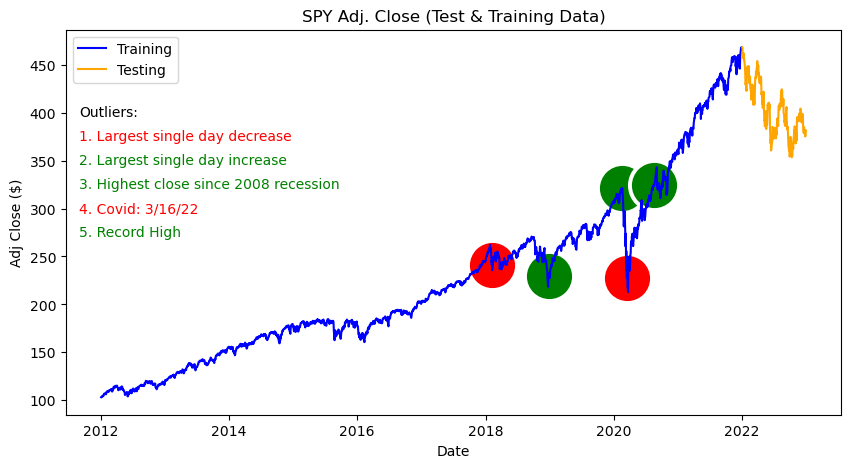

In [32]:
#Manually include good (green) & bad (red) outliers
good_outlier_dates = ['12/26/2018', '2/19/2020', '8/18/2020']
bad_outlier_dates = ['2/5/2018', '3/16/2020']

#Formatting
fig, ax = plt.subplots(figsize=(10, 5)) 
ax.set(title=str(ticker) + str(' Adj. Close') + str(' (Test & Training Data)'))
ax.set(ylabel='Adj Close ($)') #set y-axis

#Create plot
sns.lineplot(data=train_data, x='Date', y='Adj Close', label='Training', ax=ax, color= 'blue')
sns.lineplot(data=test_data, x='Date', y='Adj Close', label='Testing', ax=ax, color='orange')
sns.scatterplot(data=train_data[train_data['Date'].isin(bad_outlier_dates)], x='Date', y='Adj Close', ax=ax, color= 'red', s=1250)
sns.scatterplot(data=train_data[train_data['Date'].isin(good_outlier_dates)], x='Date', y='Adj Close', ax=ax, color= 'green', s=1250)

#Manually describe outliers
plt.text(datetime(2011,9,1),400,"Outliers:",horizontalalignment='left', verticalalignment='center')
plt.text(datetime(2011,9,1),375,"1. Largest single day decrease",horizontalalignment='left', verticalalignment='center', color='red')
plt.text(datetime(2011,9,1),350,"2. Largest single day increase",horizontalalignment='left', verticalalignment='center', color='green')
plt.text(datetime(2011,9,1),325,"3. Highest close since 2008 recession",horizontalalignment='left', verticalalignment='center', color='green')
plt.text(datetime(2011,9,1),300,"4. Covid: 3/16/22",horizontalalignment='left', verticalalignment='center',color='red')
plt.text(datetime(2011,9,1),275,"5. Record High",horizontalalignment='left', verticalalignment='center', color='green')

#Display plot
plt.show()

# 4. Visualize Daily % Change (for Test & Training Periods)

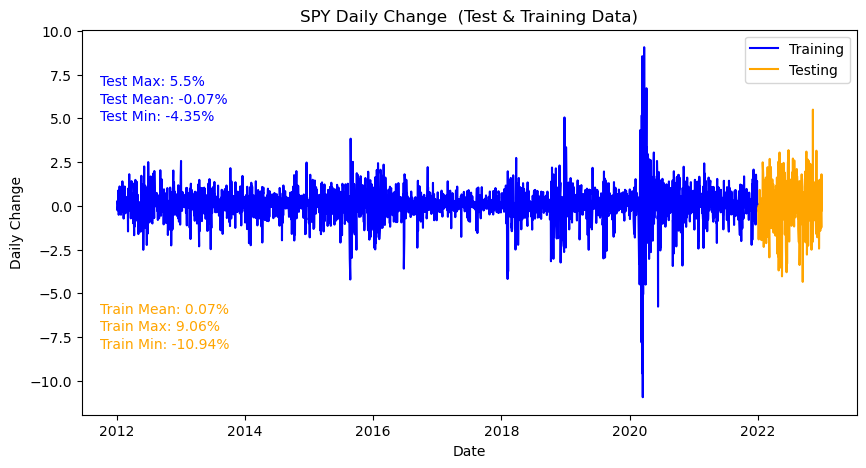

In [33]:
# Create dataframe column for daily pct change
test_data['Daily Change'] = test_data[['Adj Close']].pct_change() *100
train_data['Daily Change'] = train_data[['Adj Close']].pct_change() *100

#Formatting
fig, ax = plt.subplots(figsize=(10, 5)) #Set size
ax.set(title=str(ticker) + str(' Daily Change ') + str(' (Test & Training Data)')) #set title
ax.set(ylabel='Daily Change') #set y-axis

#Create plots
graph = sns.lineplot(data=train_data, x='Date', y='Daily Change' ,label='Training', ax=ax, color= 'blue')
graph = sns.lineplot(data=test_data, x='Date', y='Daily Change' ,label='Testing', ax=ax, color= 'orange')

#Show min/max/mean for each dataset
plt.text(datetime(2011,10,1),7.5,str("Test Max: ") + str(test_data['Daily Change'].describe().loc['max'].round(2))+str('%'),horizontalalignment='left', verticalalignment='top',color='blue')
plt.text(datetime(2011,10,1),6.5,str("Test Mean: ") + str(test_data['Daily Change'].describe().loc['mean'].round(2))+str('%'),horizontalalignment='left', verticalalignment='top',color='blue')
plt.text(datetime(2011,10,1),5.5,str("Test Min: ") + str(test_data['Daily Change'].describe().loc['min'].round(2))+str('%'),horizontalalignment='left', verticalalignment='top',color='blue')
plt.text(datetime(2011,10,1),-6.5,str("Train Max: ") + str(train_data['Daily Change'].describe().loc['max'].round(2))+str('%'),horizontalalignment='left', verticalalignment='top',color='orange')
plt.text(datetime(2011,10,1),-5.5,str("Train Mean: ") + str(train_data['Daily Change'].describe().loc['mean'].round(2))+str('%'),horizontalalignment='left', verticalalignment='top',color='orange')
plt.text(datetime(2011,10,1),-7.5,str("Train Min: ") + str(train_data['Daily Change'].describe().loc['min'].round(2))+str('%'),horizontalalignment='left', verticalalignment='top',color='orange')

#Display plot
plt.show()

# 5. Stationarity Tests (ADF)

In [34]:
#Adj Close stationarity test
if adfuller(train_data['Adj Close'])[1] > 0.05:
    print('Adj Close is non-stationary')
else:
    print('Adj Close is stationary')    
    
#Daily Change stationarity test
if adfuller(train_data['Daily Change'].iloc[1:])[1] > 0.05:
    print('Daily Change is non-stationary')
else:
    print('Daily Change is stationary')    

Adj Close is non-stationary
Daily Change is stationary


# 6. ACF and PACF Plots

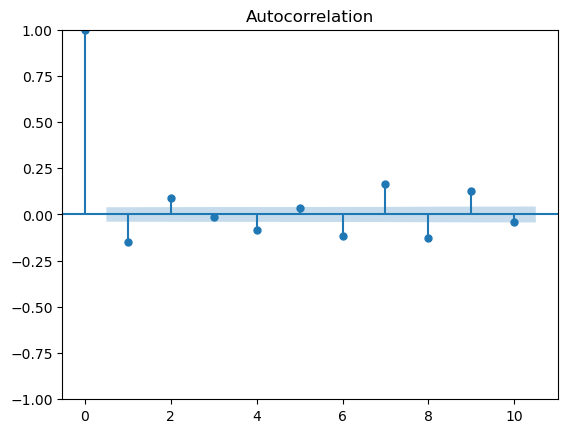

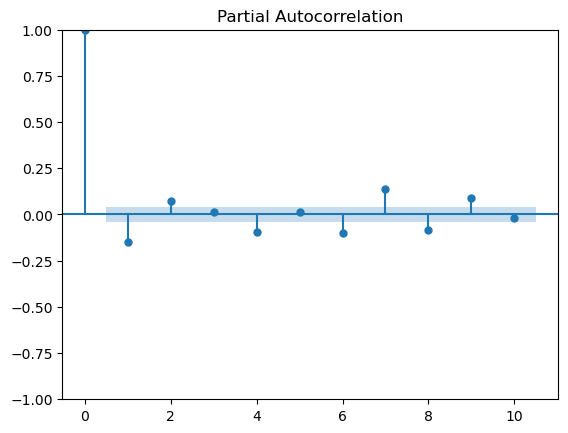

In [35]:
#Get ACF & PACF plots
plot_acf(train_data['Daily Change'].iloc[1:],lags=10)
plot_pacf(train_data['Daily Change'].iloc[1:],lags=10)

#Display plots
plt.show()

# 7. Build ARMA model by minimizing AIC

In [36]:
#Use auto-ARIMA to find the best parameters (based on AIC)
ARIMA_model = auto_arima(train_data['Daily Change'].iloc[1:], 
                      start_p=1, 
                      start_q=1,
                      max_p=10, max_q=10, 
                      d=0,
                      seasonal=False,
                      trace=True, 
                      suppress_warnings=True,
                      stepwise=True)

#Display output for best ARIMA
arima_model = ARIMA(train_data['Daily Change'], order=ARIMA_model.order)
model = arima_model.fit()
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=7166.779, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=7225.178, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=7173.271, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=7181.095, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=7162.646, Time=0.23 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=7160.866, Time=0.08 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=7162.143, Time=0.13 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=7104.690, Time=0.61 sec
 ARIMA(4,0,1)(0,0,0)[0]             : AIC=7090.277, Time=0.57 sec
 ARIMA(4,0,0)(0,0,0)[0]             : AIC=7144.913, Time=0.18 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=7091.309, Time=0.78 sec
 ARIMA(4,0,2)(0,0,0)[0]             : AIC=inf, Time=2.01 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=7056.439, Time=0.73 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=7157.918, Time=0.25 sec
 ARIMA(3,0,3)(0,0,0)[0]             : 

# 8. Out-of-sample forecast for Test period

In [37]:
#Create Forecasts for Test Period (if multiplying change %, divide by 100)
forecasts = model.forecast(steps = len(test_data.index)).reset_index(0)['predicted_mean']
test_data['Expected Daily Change'] = forecasts

#Create List of Expected Adj Close 
Adj_Close_hat = []

#Calculate First Expected Adj Close
p1 = train_data['Adj Close'].iloc[-1] * forecasts[0]/100 + train_data['Adj Close'].iloc[-1]
Adj_Close_hat.append(p1)

#Calculate Other Expected Adj Close values 
for x in (test_data.index-1):
    Adj_Close_hat.append(Adj_Close_hat[x] * forecasts[x+1]/100 + Adj_Close_hat[x])
    
#Dataframe column for Expected Adj Close
test_data['Expected Adj Close'] = Adj_Close_hat[:-1]

#Display output
display(test_data)

,Date,Adj Close,Daily Change,Expected Daily Change,Expected Adj Close
0,2022-01-03,468.30,NaN,-0.085586,465.201512
1,2022-01-04,468.14,-0.034166,-0.011570,464.803365
2,2022-01-05,459.15,-1.920366,0.181103,465.147687
3,2022-01-06,458.72,-0.093651,-0.125356,465.645136
4,2022-01-07,456.91,-0.394576,0.241796,464.564595
...,...,...,...,...,...
246,2022-12-23,381.45,0.574788,0.064170,499.593564
247,2022-12-27,379.95,-0.393236,0.064171,501.587778
248,2022-12-28,375.23,-1.242269,0.064172,499.914157
249,2022-12-29,381.98,1.798897,0.064173,501.909656


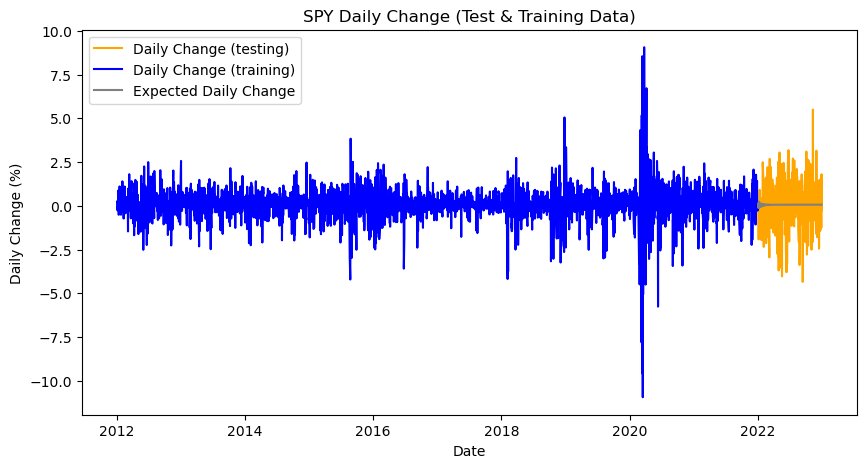

In [38]:
#Plot All Daily Change

#Formatting
fig, ax = plt.subplots(figsize=(10, 5)) 
ax.set(title=str(ticker) + str(' Daily Change') + str(' (Test & Training Data)'))
ax.set(ylabel='Daily Change (%)') #set y-axis

#Create plot
sns.lineplot(data=test_data, x='Date', y='Daily Change', label= "Daily Change (testing)", ax=ax, color= 'orange')
sns.lineplot(data=train_data, x='Date', y='Daily Change', label='Daily Change (training)', ax=ax, color= 'blue')
sns.lineplot(data=test_data, x='Date', y='Expected Daily Change', label='Expected Daily Change', ax=ax, color= 'grey')

#Display plot
plt.show()

<AxesSubplot:title={'center':'SPY Adj. Close (Test & Training Data)'}, xlabel='Date', ylabel='Adj Close ($)'>

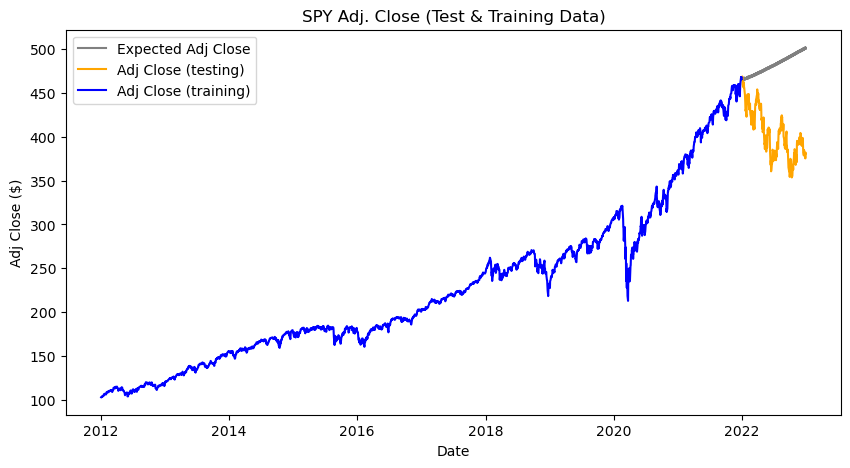

In [39]:
#Plot All Adj Close Values

#Formatting
fig, ax = plt.subplots(figsize=(10, 5)) 
ax.set(title=str(ticker) + str(' Adj. Close') + str(' (Test & Training Data)'))
ax.set(ylabel='Adj Close ($)') #set y-axis

#Create plot
sns.lineplot(data=test_data, x='Date', y='Expected Adj Close', label='Expected Adj Close', ax=ax, color= 'grey')
sns.lineplot(data=test_data, x='Date', y='Adj Close', label= "Adj Close (testing)", ax=ax, color= 'orange')
sns.lineplot(data=train_data, x='Date', y='Adj Close', label='Adj Close (training)', ax=ax, color= 'blue')

# 9. Residuals

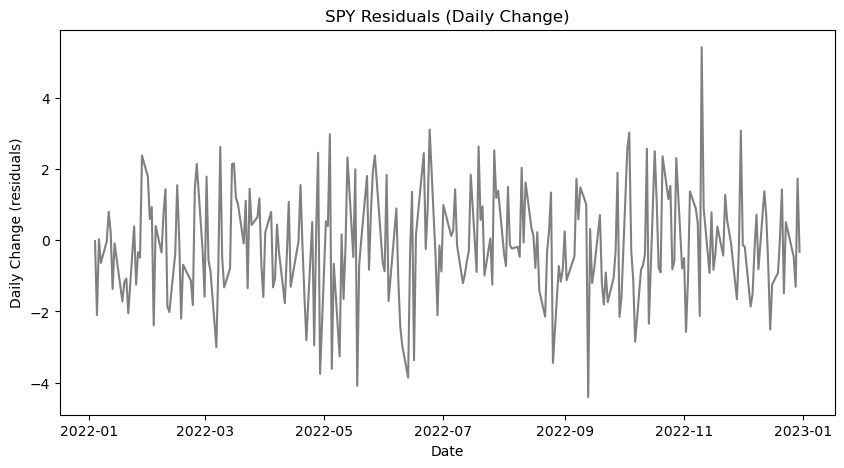

In [40]:
#Calculate Residuals in returns
test_data['Daily Change (residuals)'] = test_data['Daily Change'] - test_data['Expected Daily Change']

#Formatting
fig, ax = plt.subplots(figsize=(10, 5)) 
ax.set(title=str(ticker) + str(' Residuals') + str(' (Daily Change)'))

#Create plot of Residuals
sns.lineplot(data=test_data, x='Date', y='Daily Change (residuals)', ax=ax, color= 'grey')
plt.show()

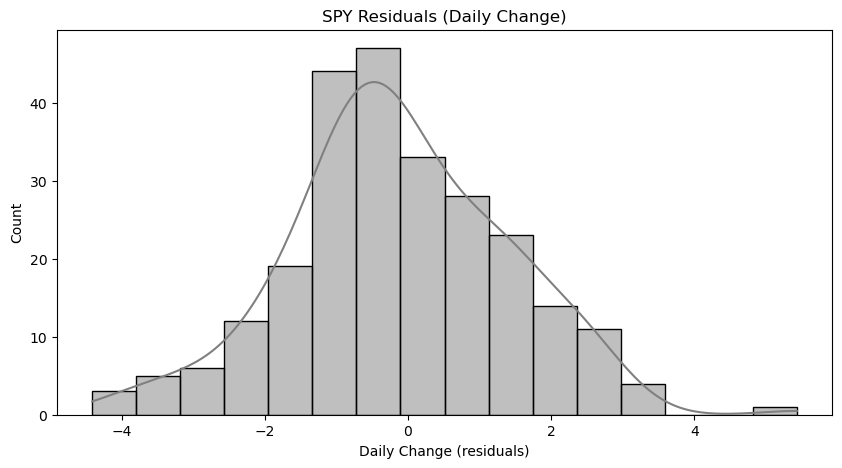

Residuals are normally distributed


In [41]:
#Shapiro-Wilk test for normality of residuals
shapiro_test = stats.shapiro(test_data['Daily Change (residuals)'])

#Output histplot of residuals
fig, ax = plt.subplots(figsize=(10, 5)) 
sns.histplot(data=test_data, x='Daily Change (residuals)', ax=ax, color= 'grey', kde=True)
ax.set(title=str(ticker) + str(' Residuals') + str(' (Daily Change)'))
plt.show()

#Print results
if shapiro_test.pvalue >0.05:
    print('Residuals are normally distributed')
else:
    print('Residuals are not normally distributed')

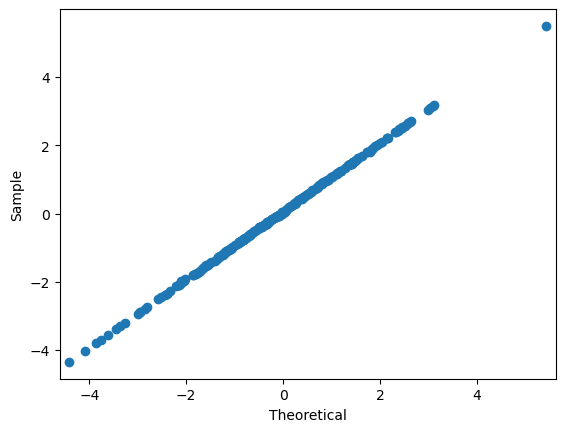

In [42]:
#QQ plot data
pp_x = sm.ProbPlot(test_data['Daily Change (residuals)'])
pp_y = sm.ProbPlot(test_data['Daily Change'])
qqplot_2samples(pp_x, pp_y,xlabel='Theoretical',ylabel='Sample')

#Display plot
plt.show()

# 10. Model 1: Using the forecasted returns

In [43]:
#Model 1: If we expect an increase tomorrow, Buy. If we expect a decrease tomorrow, Sell

#Create lists
buy = []
sell = []

#Determine indices for when to buy or sell
for x in test_data.index:
    if test_data['Expected Daily Change'].iloc[x] > 0:
        buy.append(x)
    else:
        sell.append(x)

#Manually calculated earnings
e1 =test_data['Adj Close'].iloc[12] - test_data['Adj Close'].iloc[6]
e2 = test_data['Adj Close'].iloc[5] - test_data['Adj Close'].iloc[4]
e3 = test_data['Adj Close'].iloc[3] - test_data['Adj Close'].iloc[0]

#Calculate values
print((e1+e2+e3).round(2))

-32.69


# 11. Model 2: Simple Moving Averages

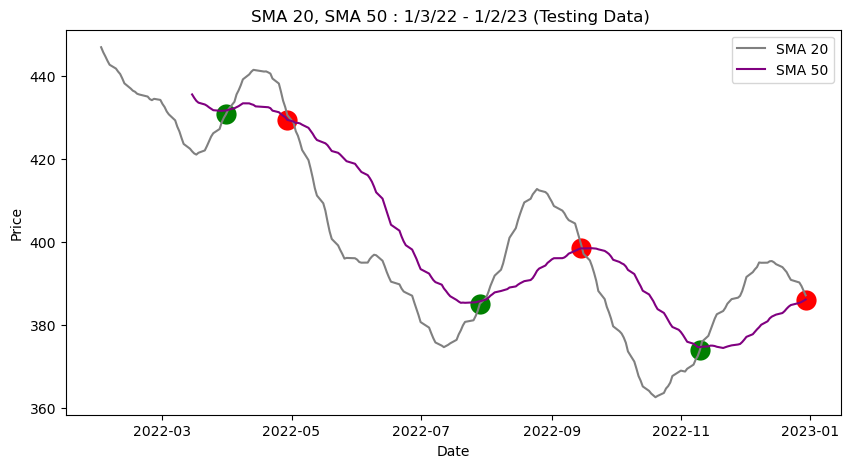

-70.99


In [44]:
#Calculate SMA values
test_data['SMA 20'] = test_data['Adj Close'].rolling(window=20).mean()
test_data['SMA 50'] = test_data['Adj Close'].rolling(window=50).mean()

#Finding important indices
test_data['SMA diff'] = abs(test_data['SMA 20'] - test_data['SMA 50'])
crossovers = list(test_data.nsmallest(10, ['SMA diff']).index) #Look at the smallest differences
indices = [x + 1 for x in crossovers]
new_crossovers = [i for i in crossovers if i not in indices] #keep the first adjacent occurence 
new_crossovers = sorted(new_crossovers)
buy_index = new_crossovers[::2]
sell_index = new_crossovers[1::2]

#Formatting
fig, ax = plt.subplots(figsize=(10, 5)) #Set size
ax.set(title='SMA 20, SMA 50 : 1/3/22 - 1/2/23 (Testing Data) ', ylabel='Price') #set title, y-axis label

#Create plots for SMA lines
sns.lineplot(data=test_data, x='Date', y='SMA 20', label='SMA 20', ax=ax, color= 'grey')
sns.lineplot(data=test_data, x='Date', y='SMA 50', label='SMA 50', ax=ax, color= 'purple')

#Highlight buy/sell signals
buy_dates = test_data['Date'].loc[new_crossovers[::2]]
sell_dates = test_data['Date'].loc[new_crossovers[1::2]]
sns.scatterplot(data=test_data[test_data['Date'].isin(buy_dates)], x='Date', y='SMA 20', ax=ax, color= 'green', s=250)
sns.scatterplot(data=test_data[test_data['Date'].isin(sell_dates)], x='Date', y='SMA 50', ax=ax, color= 'red', s=250)
plt.show()

#Calculate Earnings
print((test_data['Adj Close'].loc[sell_index].sum() - test_data['Adj Close'].loc[buy_index].sum()).round(2))

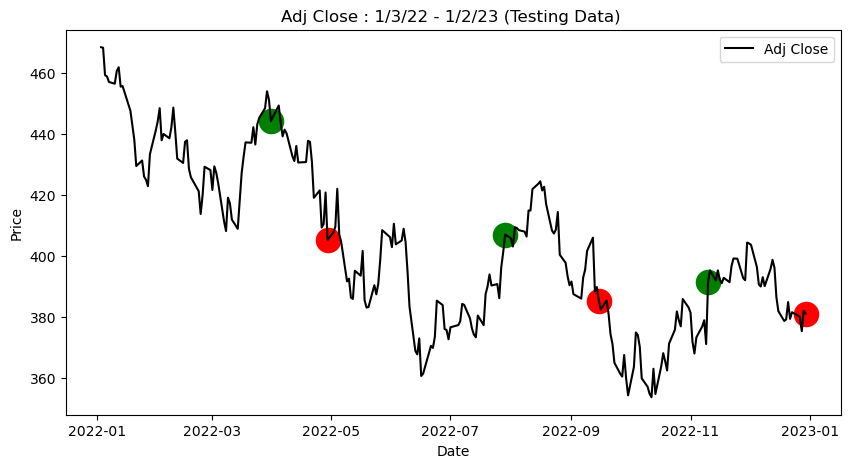

In [45]:
#Visualize the loss

#Formatting
fig, ax = plt.subplots(figsize=(10, 5)) #Set size
ax.set(title='Adj Close : 1/3/22 - 1/2/23 (Testing Data) ', ylabel='Price') #set title, y-axis label

#Create plot
sns.lineplot(data=test_data, x='Date', y='Adj Close', label='Adj Close', ax=ax, color= 'black')
sns.scatterplot(data=test_data[test_data['Date'].isin(buy_dates)], x='Date', y='Adj Close', ax=ax, color= 'green', s=400)
sns.scatterplot(data=test_data[test_data['Date'].isin(sell_dates)], x='Date', y='Adj Close', ax=ax, color= 'red', s=400)
plt.show()

# 12. Model 3: Randomly Buy/Sell

In [46]:
#Create list and set number of trials
profit_loss = [] 
n = 1000

#Caclulate earnings for n-trials
for x in range(0,n):
    rand_index = sorted(random.sample(range(test_data.index.min(),test_data.index.max()),6))
    r_buy = rand_index[::2]
    r_sell = rand_index[1::2]
    profit_loss.append(test_data['Adj Close'].loc[r_sell].sum() - test_data['Adj Close'].loc[r_buy].sum())

#Output descriptive statistics
df = pd.DataFrame(profit_loss, columns=['Earnings'])
df.describe()

,Earnings
count,1000.000000
mean,-28.027630
std,37.833837
min,-152.420000
25%,-53.020000
50%,-28.455000
75%,-1.152500
max,77.500000


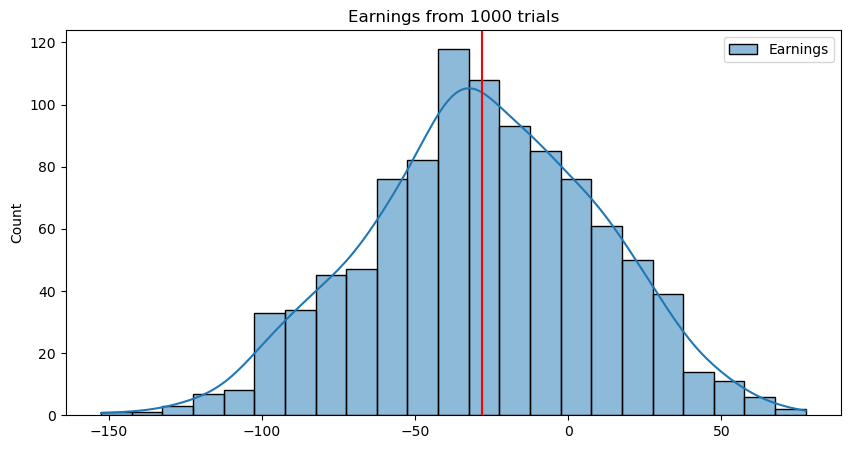

In [47]:
#Formatting
fig, ax = plt.subplots(figsize=(10, 5)) #Set size
ax.set(title=str('Earnings from ') + str(n) +  str(' trials')) #set title

#Plot earnings
graph1 = sns.histplot(data=df, ax=ax, color= 'blue', kde=True)
graph1.axvline(df.describe().loc['mean'][0], color='red') #vertical line at mean
plt.show()